In [2]:
import reading
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten, InputLayer, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Conv3D, AveragePooling2D, AveragePooling3D, MaxPooling2D, MaxPooling3D,GlobalAvgPool2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_curve, auc
import os
from tensorflow.keras import layers

Import dataset

In [5]:
paths_FA= reading.data_path("Diffusion_parameters_maps-20230215T134959Z-001","corrected_FA_image")
paths_MD= reading.data_path("Diffusion_parameters_maps-20230215T134959Z-001","corrected_MD_image")
paths_AD= reading.data_path("Diffusion_parameters_maps-20230215T134959Z-001","corrected_AD_image")
paths_RD= reading.data_path("Diffusion_parameters_maps-20230215T134959Z-001","corrected_RD_image")

#paths_FA.sort(key=lambda x: int(os.path.basename(x).split('_')[3]))
#paths_MD.sort(key=lambda x: int(os.path.basename(x).split('_')[3]))
#paths_AD.sort(key=lambda x: int(os.path.basename(x).split('_')[3]))
#paths_RD.sort(key=lambda x: int(os.path.basename(x).split('_')[3]))

dataset=pd.DataFrame(pd.read_csv('ADNI_dataset_diffusion.csv'))
#dataset.sort_values(by=["Subject"],inplace=True)
dataset["Path FA"]=paths_FA
dataset["Path MD"]=paths_MD
dataset["Path AD"]=paths_AD
dataset["Path RD"]=paths_RD
pd.set_option("max_colwidth",None)

In [7]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(dataset)

    Subject  Group  Sex   Age  \
0      4081      0    F  73.0   
1      4119      0    M  79.0   
2      4136      1    M  67.0   
3      4142      1    F  90.0   
4      4152      1    M  61.0   
5      4288      0    F  73.0   
6      4350      0    M  73.0   
7      4373      1    F  71.0   
8      4441      0    F  69.0   
9      4555      0    F  66.0   
10     4644      0    F  68.0   
11     4839      0    M  66.0   
12     4840      0    F  62.0   
13     4872      0    F  69.0   
14     4892      1    F  75.0   
15     4900      0    F  60.0   
16     5187      1    F  62.0   
17     4707      1    M  68.0   
18     4910      1    F  82.0   
19     5038      1    M  82.0   
20     5119      1    F  77.0   
21     4387      0    F  76.0   
22     4488      0    M  73.0   
23     4516      0    M  71.0   
24     4568      1    F  71.0   
25     4620      0    M  77.0   
26     4637      0    F  71.0   
27     5196      1    F  73.0   
28     4009      1    M  90.0   
29     409

In [9]:
for i in range(97):
    print(dataset["Group"][i], dataset["Path FA"][i])

0 Diffusion_parameters_maps-20230215T134959Z-001\Diffusion_parameters_maps\003_S_4081\corrected_FA_image\ADNI_003_S_4081_MR_corrected_FA_image_Br_20120421203936832_S114205_I299596.nii
0 Diffusion_parameters_maps-20230215T134959Z-001\Diffusion_parameters_maps\003_S_4119\corrected_FA_image\ADNI_003_S_4119_MR_corrected_FA_image_Br_20120421203957860_S118964_I299597.nii
1 Diffusion_parameters_maps-20230215T134959Z-001\Diffusion_parameters_maps\003_S_4136\corrected_FA_image\2011-08-10_15_34_32.0\I299599\ADNI_003_S_4136_MR_corrected_FA_image_Br_20120421204050825_S118504_I299599.nii
1 Diffusion_parameters_maps-20230215T134959Z-001\Diffusion_parameters_maps\003_S_4142\corrected_FA_image\2011-08-31_15_32_27.0\I299601\ADNI_003_S_4142_MR_corrected_FA_image_Br_20120421204138926_S121325_I299601.nii
1 Diffusion_parameters_maps-20230215T134959Z-001\Diffusion_parameters_maps\003_S_4152\corrected_FA_image\2011-08-30_09_55_00.0\I299602\ADNI_003_S_4152_MR_corrected_FA_image_Br_20120421204200489_S120805_I2

In [4]:
images_list = []
k_slice = 45

for i, datapath in enumerate(dataset["Path FA"]):
    image_FA = np.asarray(nib.load(dataset["Path FA"][i]).get_fdata())
    image_MD = np.asarray(nib.load(dataset["Path MD"][i]).get_fdata())
    image_AD = np.asarray(nib.load(dataset["Path AD"][i]).get_fdata())
    image = np.stack((image_FA[k_slice], image_MD[k_slice], image_AD[k_slice]), axis=-1)
    images_list.append(image)
    
images = np.array(images_list, dtype='float64')
labels = np.array(dataset["Group"], dtype='int64')

print(np.shape(images))

(97, 110, 110, 3)


Data augmentation

In [5]:
'''
augmentation_rot = Sequential([layers.RandomRotation((-0.5,0.5))])
augmentation_zoom = Sequential([layers.RandomZoom(0.5)])

images_rotated = augmentation_rot(images)
images_zoomed = augmentation_zoom(images)

images = np.concatenate((images, images_rotated, images_zoomed), axis = 0)

labels = np.concatenate((labels, labels, labels))
'''

'\naugmentation_rot = Sequential([layers.RandomRotation((-0.5,0.5))])\naugmentation_zoom = Sequential([layers.RandomZoom(0.5)])\n\nimages_rotated = augmentation_rot(images)\nimages_zoomed = augmentation_zoom(images)\n\nimages = np.concatenate((images, images_rotated, images_zoomed), axis = 0)\n\nlabels = np.concatenate((labels, labels, labels))\n'

Train-Validation-Test splitting

In [6]:
def split_2D():
    X_train, x_test, Y_train, y_test = train_test_split(images[:,:,:], labels, test_size=0.2, random_state=10)
    x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=20)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [7]:
x_train, y_train, x_val, y_val, x_test, y_test = split_2D()
print(x_train.shape)

(57, 110, 110, 3)


Defining 2.5-D CNN model

In [9]:
def make_2D_CNN_best(shape=(110, 110, 3)):
  model = Sequential([
      
      Conv2D(2, (3,3), padding='valid', input_shape=shape, kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((3,3), strides=3),
      #Dropout(0.4),
      
      Conv2D(4, (3,3), padding='valid', input_shape=shape, kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((2,2), strides=2),
      #Dropout(0.4),
      
      Conv2D(8, (3,3), padding='valid', input_shape=shape, kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((2,2), strides=2),
      #Dropout(0.4),
      
      Flatten(),

      Dense(128, activation='relu'),
      #Dropout(0.1),
      Dense(1, activation='sigmoid')
     
  ])
  return model

In [173]:
def make_2D_CNN(shape=(110, 110, 3)):
  model = Sequential([
      
      Conv2D(2, (3,3), padding='valid', input_shape=shape, kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((3,3), strides=3),
      #Dropout(0.4),
      
      Conv2D(4, (3,3), padding='valid', input_shape=shape, kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((2,2), strides=2),
      #Dropout(0.4),
      
      Conv2D(8, (3,3), padding='valid', input_shape=shape, kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((2,2), strides=2),
      #Dropout(0.4),
      
      Conv2D(16, (3,3), padding='valid', input_shape=shape, kernel_regularizer='l2'),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((2,2), strides=2),
      #Dropout(0.4),
      
      Flatten(),

      Dense(32, activation='relu'),
      #Dropout(0.1),
      Dense(1, activation='sigmoid')
     
  ])
  return model

Create the model

In [174]:
model = make_2D_CNN()
model.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_167 (Conv2D)         (None, 108, 108, 2)       56        
                                                                 
 batch_normalization_167 (Ba  (None, 108, 108, 2)      8         
 tchNormalization)                                               
                                                                 
 activation_167 (Activation)  (None, 108, 108, 2)      0         
                                                                 
 max_pooling2d_167 (MaxPooli  (None, 36, 36, 2)        0         
 ng2D)                                                           
                                                                 
 conv2d_168 (Conv2D)         (None, 34, 34, 4)         76        
                                                                 
 batch_normalization_168 (Ba  (None, 34, 34, 4)      

Compile and training the model

In [175]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=100,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=10)

epochs= 1000
batch_size = 10
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch = round(len(x_train)/batch_size),
                    verbose=1,
                    validation_data=(x_val, y_val),
                    validation_steps=round(len(x_val)/batch_size),
                    callbacks=[reduce_on_plateau, early_stopping])

Epoch 1/1000
6/6 [==============================] - 3s 124ms/step - loss: 0.9867 - accuracy: 0.4737 - val_loss: 0.8962 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/1000
6/6 [==============================] - 0s 66ms/step - loss: 0.9624 - accuracy: 0.4912 - val_loss: 0.8959 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 3/1000
6/6 [==============================] - 0s 69ms/step - loss: 0.9328 - accuracy: 0.5263 - val_loss: 0.8959 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 4/1000
6/6 [==============================] - 0s 69ms/step - loss: 0.9150 - accuracy: 0.5614 - val_loss: 0.8956 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 5/1000
6/6 [==============================] - 0s 67ms/step - loss: 0.9024 - accuracy: 0.6140 - val_loss: 0.8955 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 6/1000
6/6 [==============================] - 0s 70ms/step - loss: 0.8968 - accuracy: 0.5789 - val_loss: 0.8953 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 7/1000
6/6 [==============================] -

6/6 [==============================] - 0s 45ms/step - loss: 0.6813 - accuracy: 0.8070 - val_loss: 0.8906 - val_accuracy: 0.5000 - lr: 1.0000e-11
Epoch 104/1000
6/6 [==============================] - 0s 42ms/step - loss: 0.6842 - accuracy: 0.8070 - val_loss: 0.8875 - val_accuracy: 0.5000 - lr: 1.0000e-11
Epoch 105/1000
6/6 [==============================] - 0s 42ms/step - loss: 0.6861 - accuracy: 0.8070 - val_loss: 0.8845 - val_accuracy: 0.5000 - lr: 1.0000e-11
Epoch 106/1000
6/6 [==============================] - 0s 43ms/step - loss: 0.6872 - accuracy: 0.8421 - val_loss: 0.8817 - val_accuracy: 0.5000 - lr: 1.0000e-11
Epoch 107/1000
6/6 [==============================] - 0s 40ms/step - loss: 0.6903 - accuracy: 0.8070 - val_loss: 0.8793 - val_accuracy: 0.5000 - lr: 1.0000e-11
Epoch 108/1000
6/6 [==============================] - 0s 40ms/step - loss: 0.6847 - accuracy: 0.8421 - val_loss: 0.8773 - val_accuracy: 0.5000 - lr: 1.0000e-11
Epoch 109/1000
6/6 [==============================] - 0

6/6 [==============================] - 0s 42ms/step - loss: 0.6916 - accuracy: 0.8421 - val_loss: 0.8476 - val_accuracy: 0.7000 - lr: 1.0000e-12
Epoch 206/1000
6/6 [==============================] - 0s 41ms/step - loss: 0.6838 - accuracy: 0.8246 - val_loss: 0.8476 - val_accuracy: 0.7000 - lr: 1.0000e-12
Epoch 207/1000
6/6 [==============================] - 0s 41ms/step - loss: 0.6802 - accuracy: 0.8070 - val_loss: 0.8476 - val_accuracy: 0.7000 - lr: 1.0000e-12
Epoch 208/1000
6/6 [==============================] - 0s 46ms/step - loss: 0.6852 - accuracy: 0.8070 - val_loss: 0.8475 - val_accuracy: 0.7000 - lr: 1.0000e-12
Epoch 209/1000
6/6 [==============================] - 0s 42ms/step - loss: 0.6892 - accuracy: 0.8070 - val_loss: 0.8475 - val_accuracy: 0.7000 - lr: 1.0000e-12
Epoch 210/1000
6/6 [==============================] - 0s 42ms/step - loss: 0.6891 - accuracy: 0.8070 - val_loss: 0.8475 - val_accuracy: 0.7000 - lr: 1.0000e-12
Epoch 211/1000
6/6 [==============================] - 0

6/6 [==============================] - 0s 42ms/step - loss: 0.6823 - accuracy: 0.8246 - val_loss: 0.8471 - val_accuracy: 0.7000 - lr: 1.0000e-21
Epoch 308/1000
6/6 [==============================] - 0s 43ms/step - loss: 0.6875 - accuracy: 0.8070 - val_loss: 0.8471 - val_accuracy: 0.7000 - lr: 1.0000e-21
Epoch 309/1000
6/6 [==============================] - 0s 41ms/step - loss: 0.6837 - accuracy: 0.8246 - val_loss: 0.8471 - val_accuracy: 0.7000 - lr: 1.0000e-21
Epoch 310/1000
6/6 [==============================] - 0s 41ms/step - loss: 0.6878 - accuracy: 0.8070 - val_loss: 0.8471 - val_accuracy: 0.7000 - lr: 1.0000e-21
Epoch 311/1000
6/6 [==============================] - 0s 43ms/step - loss: 0.6888 - accuracy: 0.8070 - val_loss: 0.8471 - val_accuracy: 0.7000 - lr: 1.0000e-21
Epoch 312/1000
6/6 [==============================] - 0s 42ms/step - loss: 0.6870 - accuracy: 0.8246 - val_loss: 0.8471 - val_accuracy: 0.7000 - lr: 1.0000e-21
Epoch 313/1000
6/6 [==============================] - 0

Show training results on Training set and Validation set

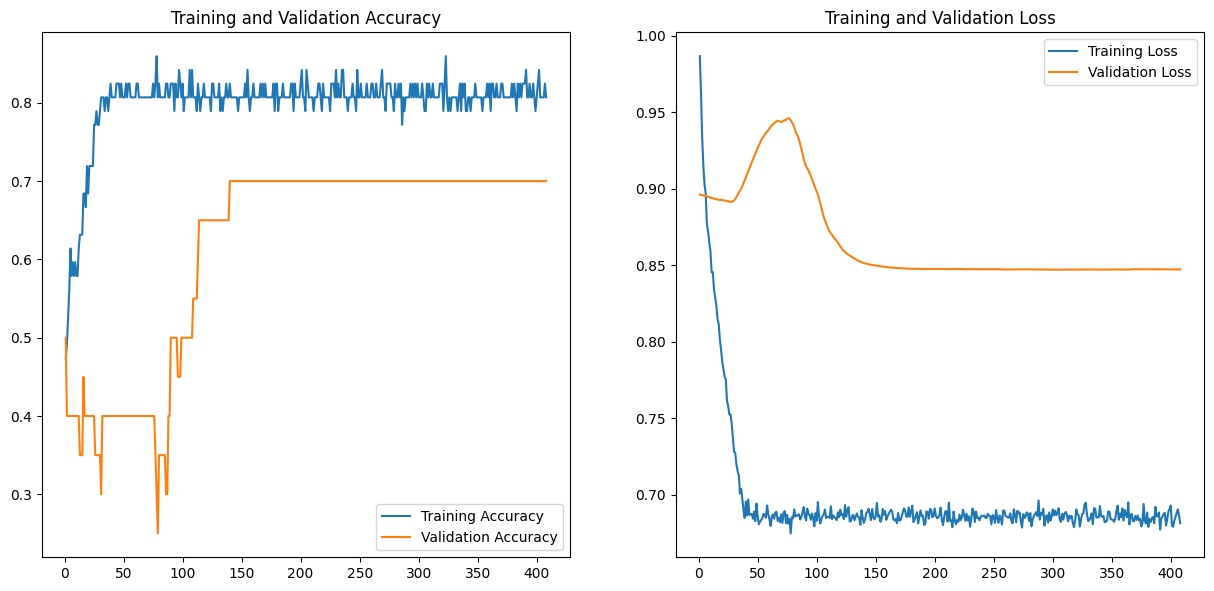

In [176]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)
#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Accuracy ROC

Validation accuracy: 0.700
1/1 [==============================] - 0s 125ms/step
AUC = 0.635


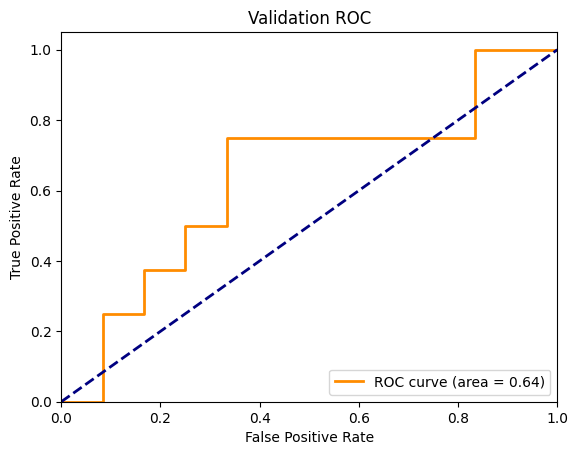

In [177]:
_, val_acc = model.evaluate(x_val, y_val, verbose=0)
print('Validation accuracy: %.3f' % (val_acc))

preds = model.predict(x_val, verbose=1)
#Compute Receiver operating characteristic (ROC)
fpr, tpr, _ = roc_curve(y_val, preds)
roc_auc = auc(fpr, tpr)
print('AUC = %.3f'% (roc_auc))

#Plot of a ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC')
plt.legend(loc="lower right")
plt.show()

Test ROC

1/1 [==============================] - 0s 47ms/step - loss: 0.7828 - accuracy: 0.7500

Test accuracy: 0.750
1/1 [==============================] - 0s 47ms/step
AUC = 0.808


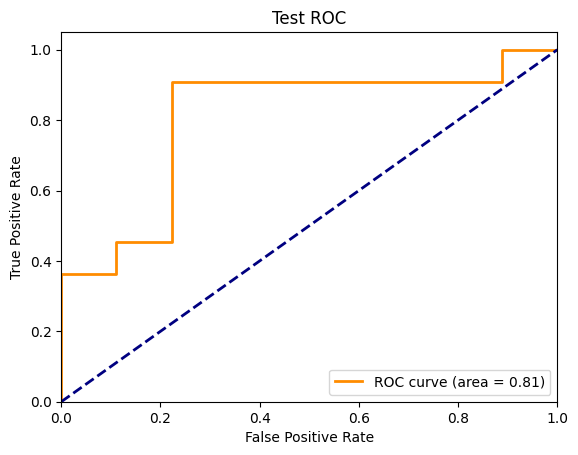

In [178]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy: %.3f' % (test_acc))

preds_test = model.predict(x_test, verbose=1)
fpr, tpr, _ = roc_curve(y_test, preds_test)
roc_auc = auc(fpr, tpr)
print('AUC = %.3f'% (roc_auc))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.legend(loc="lower right")
plt.show()